In [1]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


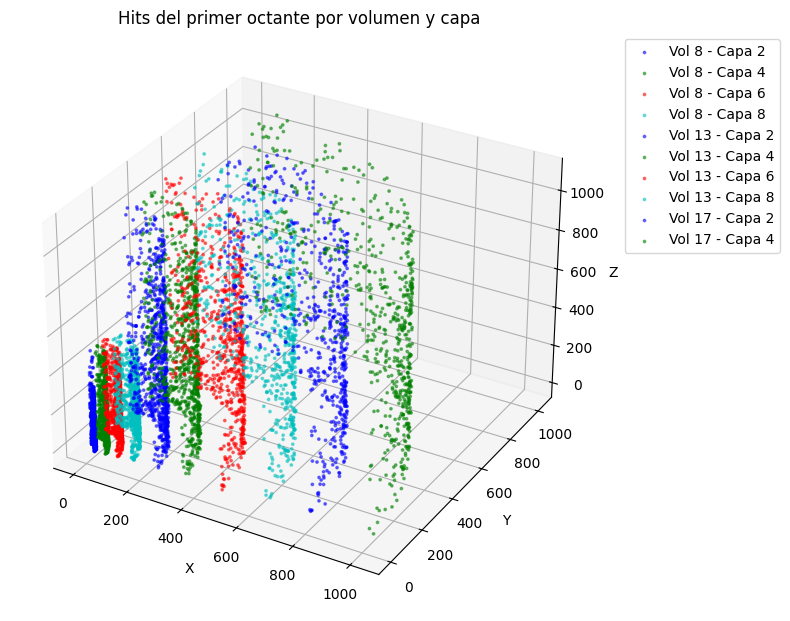

In [2]:
from kalman_filter import get_hits_dict

volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]  # Selección específica de volúmenes
first_volume = volume_ids[0]

hits_dict = get_hits_dict(hits, volume_ids, OCTANTE = True)
# Sacar los hits de hits_dict

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

for v_idx, volume_id in enumerate(hits_dict.keys()):
    subdict = hits_dict[volume_id]
    for l_idx, (layer_id, df) in enumerate(subdict.items()):
        color = colors[l_idx % len(colors)]
        ax.scatter(df['x'], df['y'], df['z'], s=3, alpha=0.5, 
                   label=f'Vol {volume_id} - Capa {layer_id}', c=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Hits del primer octante por volumen y capa')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Buscamos triplets entre las tres primeras layers

In [3]:
import tqdm
for vol in hits_dict:
   print(f"Volume {vol}: layers disponibles -> {list(hits_dict[vol].keys())}")

layer1 = hits_dict[first_volume][2]
layer2 = hits_dict[first_volume][4]
layer3 = hits_dict[first_volume][6]

# De momento quitamos el ruido
particles = particles[particles['particle_id'] != 0]

layer1 = layer1.merge(truth[['hit_id', 'particle_id']], on='hit_id', how='left')
layer2 = layer2.merge(truth[['hit_id', 'particle_id']], on='hit_id', how='left')
layer3 = layer3.merge(truth[['hit_id', 'particle_id']], on='hit_id', how='left')

layer1_particles = layer1.set_index('particle_id')
layer2_particles = layer2.set_index('particle_id')
layer3_particles = layer3.set_index('particle_id')

# Limitamos para que no explote en combinaciones
layer1_hits = layer1.sample(n=15, random_state=1)
layer2_hits = layer2.sample(n=15, random_state=1)
layer3_hits = layer3.sample(n=15, random_state=1)


from tqdm import tqdm
triplets = []
labels = []

# Generar triplets aleatorios (negativos)
for _, h1 in tqdm(layer1_hits.iterrows(), total=len(layer1_hits), desc="Layer 1"):
    for _, h2 in layer2_hits.iterrows():
        for _, h3 in layer3_hits.iterrows():
            triplet = np.concatenate([
                h1[['x', 'y', 'z']].values,
                h2[['x', 'y', 'z']].values,
                h3[['x', 'y', 'z']].values
            ])
            triplets.append(triplet)
            same_pid = h1.particle_id == h2.particle_id == h3.particle_id
            labels.append(1 if same_pid and h1.particle_id != 0 else 0)

            
# Generar triplets válidos (positivos) con condición de propagación hacia adelante
valid_triplets = []
valid_labels = []

for pid in particles['particle_id'].unique():
    h1 = layer1[layer1['particle_id'] == pid]
    h2 = layer2[layer2['particle_id'] == pid]
    h3 = layer3[layer3['particle_id'] == pid]

    # Orden secuencial (h1 -> h2 -> h3)
    if not h1.empty and not h2.empty and not h3.empty:
        
        # Ordenamos los hits por la posición en Z (o cualquier otra variable de propagación temporal)
        h1 = h1.sort_values(by="r").iloc[0]  
        h2 = h2.sort_values(by="r").iloc[0]  
        h3 = h3.sort_values(by="r").iloc[0]  
        
        # Ahora creamos el triplet
        triplet = np.concatenate([
            h1[['x', 'y', 'z']].values,
            h2[['x', 'y', 'z']].values,
            h3[['x', 'y', 'z']].values
        ])
        valid_triplets.append(triplet)
        valid_labels.append(1)  # Todos son positivos, así que etiqueta 1

# Ahora agregamos los triplets válidos a la lista
triplets.extend(valid_triplets)
labels.extend(valid_labels)

X = np.array(triplets)
y = np.array(labels)

print(f"Triplets generados: {X.shape}")

Volume 8: layers disponibles -> [np.int32(2), np.int32(4), np.int32(6), np.int32(8)]
Volume 13: layers disponibles -> [np.int32(2), np.int32(4), np.int32(6), np.int32(8)]
Volume 17: layers disponibles -> [np.int32(2), np.int32(4)]


Layer 1: 100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Triplets generados: (3892, 9)


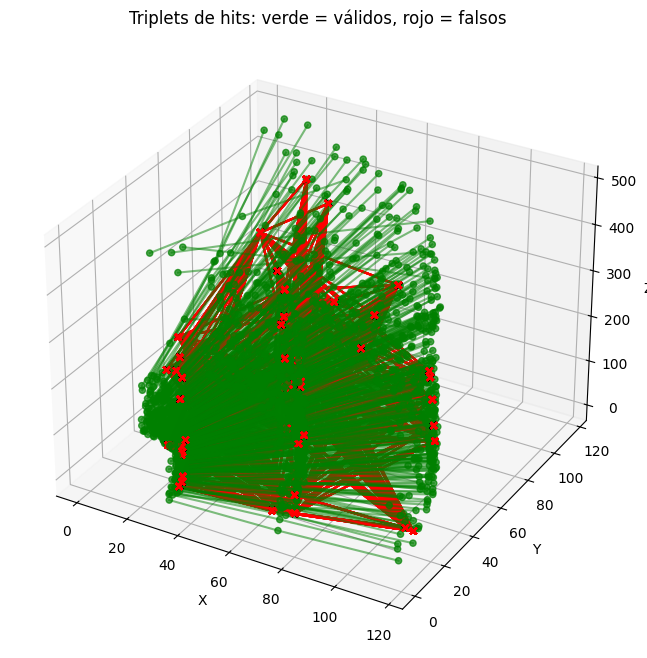

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    triplet_xyz = X[i].reshape(3, 3)  # Cada triplete son 3 puntos en (x, y, z)
    color = 'g' if y[i] == 1 else 'r'
    marker = 'o' if y[i] == 1 else 'x'
    
    # Graficamos la línea conectando los tres puntos
    ax.plot(triplet_xyz[:, 0], triplet_xyz[:, 1], triplet_xyz[:, 2], c=color, alpha=0.5)
    
    # También puedes visualizar los puntos
    ax.scatter(triplet_xyz[:, 0], triplet_xyz[:, 1], triplet_xyz[:, 2], c=color, marker=marker, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triplets de hits: verde = válidos, rojo = falsos')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Normalizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X: triplets, y: etiquetas
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Hacemos una red densa
model = Sequential([
    Dense(64, activation='relu', input_shape=(9,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

2025-05-07 12:40:25.878832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 12:40:25.882610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 12:40:25.893231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746614425.911266   17072 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746614425.916598   17072 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746614425.930330   17072 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/10


/mnt_pool/c3_users/user/uo290313/Desktop/TFG/repositorioTFG/myenv/lib64/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-07 12:40:40.421993: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7025 - loss: 0.5402 - val_accuracy: 0.9085 - val_loss: 0.2375
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9416 - loss: 0.1603 - val_accuracy: 0.9454 - val_loss: 0.1342
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.0909 - val_accuracy: 0.9743 - val_loss: 0.0959
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9868 - loss: 0.0642 - val_accuracy: 0.9759 - val_loss: 0.0768
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0470 - val_accuracy: 0.9823 - val_loss: 0.0622
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0426 - val_accuracy: 0.9823 - val_loss: 0.0538
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0316 - val_accuracy: 0.9823 - val_loss: 0.0480
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0267 - val_accuracy: 0.9823 - val_loss: 0.0451
Epo

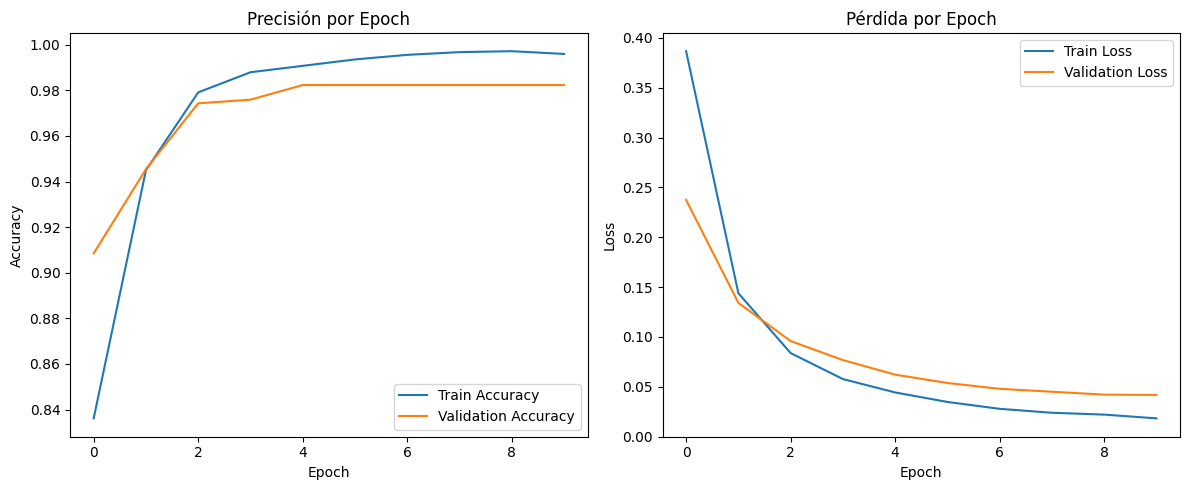

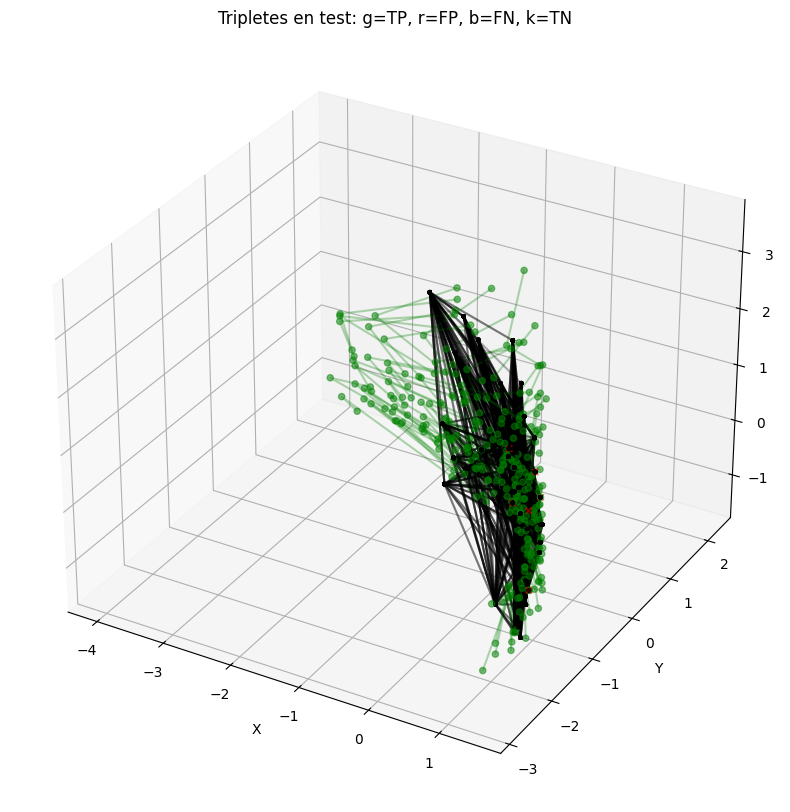

In [6]:
# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión por Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida por Epoch')
plt.legend()

plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X_test)):
    triplet_xyz = X_test[i].reshape(3, 3)
    pred = y_pred[i]
    true = y_test[i]
    
    if pred == true == 1:
        color, marker = 'g', 'o'  # Verdadero positivo
    elif pred == 1 and true == 0:
        color, marker = 'r', 'x'  # Falso positivo
    elif pred == 0 and true == 1:
        color, marker = 'b', '^'  # Falso negativo
    else:
        color, marker = 'k', '.'  # Verdadero negativo
    
    ax.plot(triplet_xyz[:, 0], triplet_xyz[:, 1], triplet_xyz[:, 2], color=color, alpha=0.3)
    ax.scatter(triplet_xyz[:, 0], triplet_xyz[:, 1], triplet_xyz[:, 2], c=color, marker=marker, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Tripletes en test: g=TP, r=FP, b=FN, k=TN')
plt.show()
